<a href="https://colab.research.google.com/github/tg-bomze/collection-of-notebooks/blob/master/Panorama_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b><font color="black" size="+4">Panorama generator</font></b>

<b><font color="black" size="+2">Based on:</font></b>

**GitHub repository**: [alis](https://github.com/universome/alis)

Article: [Aligning Latent and Image Spaces to Connect the Unconnectable](https://arxiv.org/abs/2104.06954)

Creator: **[Ivan Skorokhodov](https://universome.github.io/)**

<b><font color="black" size="+2">Colab created by:</font></b>

GitHub: [@tg-bomze](https://github.com/tg-bomze),
Telegram: [@bomze](https://t.me/bomze),
Twitter: [@tg_bomze](https://twitter.com/tg_bomze).

---


```
(ENG) To get started, click on the button (where the red arrow indicates). After clicking, wait until the execution is complete.
```
```
(RUS) Чтобы начать, поочередно нажимайте на кнопки (куда указывают красные стрелки), дожидаясь завершения выполнения каждого блока.
```


In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Install all necessary libraries</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Установить все необходимые библиотеки</font></b>
!git clone https://github.com/universome/alis
!pip install --upgrade omegaconf
!pip install torch==1.7.1 
!pip install torchvision==0.8.2 
!pip install hydra-core==1.0.6 
!pip install click==7.1.2 
!pip install scipy==1.6.1 
!pip install ninja==1.10.0 
!pip install tensorboard==2.4.1 
!pip install tqdm==4.59.0 
!pip install gitpython 
!pip install scikit-learn

%cd /content/alis

from IPython.display import clear_output
import os
from PIL import Image
import argparse
from tqdm import tqdm
import torch
import torchvision.transforms.functional as TVF
import numpy as np
from distutils.dir_util import copy_tree
from training.networks import SynthesisLayer
from training.networks import PatchWiseSynthesisLayer
import dnnlib
from scripts.legacy import load_network_pkl
import random

np.random.seed(random.randint(1,999999))
torch.manual_seed(random.randint(1,999999))
torch.set_grad_enabled(False)

network_pkl = 'https://vision-cair.s3.amazonaws.com/alis/lhq1024-snapshot.pkl'
device = 'cuda'

with dnnlib.util.open_url(network_pkl) as f:
    G = load_network_pkl(f)['G_ema'].to(device) # type: ignore
    G.eval()
    G.progressive_growing_update(100000)

for res in G.synthesis.block_resolutions:
    block = getattr(G.synthesis, f'b{res}')
    if hasattr(block, 'conv0'):
        block.conv0.use_noise = False
    block.conv1.use_noise = False
clear_output()
print('Done!')

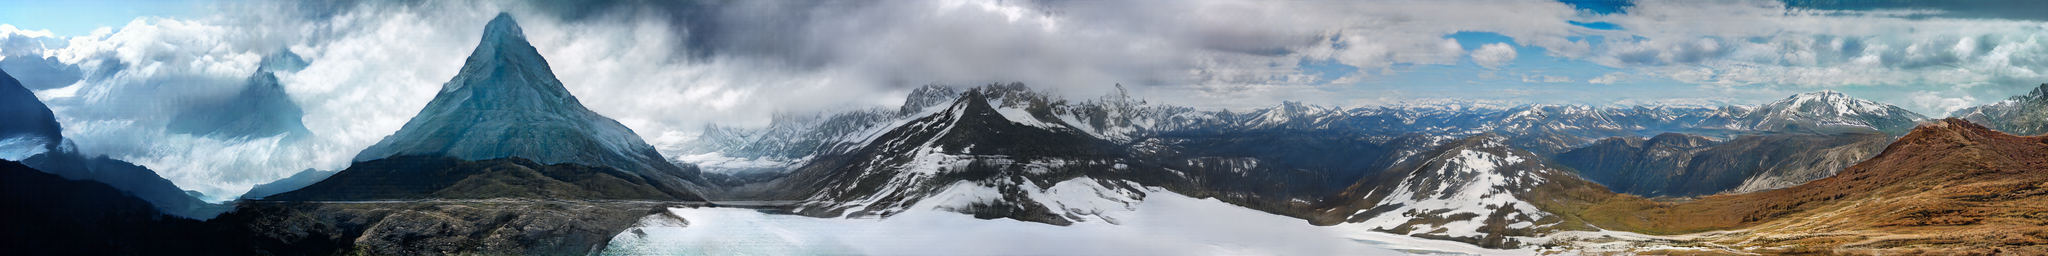

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Generate a panorama</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Генерируем панараму</font></b>

height = 1024 #@param [256, 512, 1024]
width_scale = 8 #@param {type:"slider", min:4, max:32, step:4}

num_frames_per_w = G.synthesis_cfg.patchwise.w_coord_dist // 2
num_ws = width_scale // num_frames_per_w + 1
shifts = torch.arange(width_scale) * G.synthesis_cfg.patchwise.grid_size
w_range = 2 * num_frames_per_w * G.synthesis_cfg.patchwise.grid_size
max_shift = (num_frames_per_w * 2 - 1) * G.synthesis_cfg.patchwise.grid_size
zs = torch.randn(num_ws, G.z_dim).to(device) 
mode_idx = 0
modes_idx = (torch.ones(1, device=zs.device).repeat(num_ws).float() * mode_idx).long()
ws = G.mapping(zs, c=None, modes_idx=modes_idx)

z_mean = torch.randn(1000, G.z_dim).to(device)
ws_proto = G.mapping(z_mean, c=None, modes_idx=modes_idx[0]).mean(dim=0, keepdim=True)

# Truncating
truncation_factor = 1.0
ws = ws * truncation_factor + (1 - truncation_factor) * ws_proto

imgs = []
curr_w_idx = 1
curr_ws = ws[curr_w_idx].unsqueeze(0)
curr_ws_context = torch.stack([ws[curr_w_idx - 1].unsqueeze(0), ws[curr_w_idx + 1].unsqueeze(0)], dim=1)

for shift in shifts:
    if shift > 0 and shift % w_range == 0:
        curr_w_idx += 2
        curr_ws = ws[curr_w_idx].unsqueeze(0)
        curr_ws_context = torch.stack([ws[curr_w_idx - 1].unsqueeze(0), ws[curr_w_idx + 1].unsqueeze(0)], dim=1)

    curr_left_borders_idx = torch.zeros(1, device=zs.device).long() + (shift % w_range)
    img = G.synthesis(curr_ws, ws_context=curr_ws_context, left_borders_idx=curr_left_borders_idx, noise='const')
    imgs.append(img[0].cpu().clamp(-1, 1) * 0.5 + 0.5)

whole_img = torch.cat(imgs, dim=2)
clear_output()
TVF.resize(TVF.to_pil_image(whole_img), 256, interpolation=Image.LANCZOS)

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Generate a video</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Генерируем видео</font></b>

import os
from PIL import Image
import torch
import torchvision.transforms.functional as TVF

import numpy as np
import scipy.misc
import cv2
from tqdm import tqdm

# Load data
resize_height = "1024" #@param [256, 512, 1024]
frames = [TVF.to_pil_image(img) for img in imgs]
frames = [TVF.resize(img, resize_height, interpolation=Image.LANCZOS) for img in frames]

speed = 5 #@param {type:"slider", min:1, max:20, step:1}
aspect_ratio = 2 #@param {type:"slider", min:1, max:4, step:1}
fps = "60" #@param [30, 60]

h = resize_height
w = resize_height * aspect_ratio
whole_img = torch.cat([TVF.to_tensor(im) for im in frames], dim=2)
num_frames = (whole_img.shape[2] - w) // speed
curr_offset = 0

vid_dur = int(num_frames/int(fps))
print(f'(Eng) The duration of the video will be: {vid_dur} seconds.')
print('Press Enter to start or stop the block execution and change parameters.\n')
print(f'(Rus) Длительность видео составит: {vid_dur} секунд.')
print('Нажмите Enter для старта или остановите выполнение блока и поменяйте параметры.')
start = input('')
clear_output()

save_path = '/content/alis/video.mp4'
fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
video = cv2.VideoWriter(save_path, fourcc, int(fps), (w, h))
for frame_idx in tqdm(range(num_frames)):
    curr_offset += speed
    frame = whole_img[:, :, curr_offset:curr_offset + w]
    frame = TVF.to_pil_image(frame)
    video.write(cv2.cvtColor(np.array(frame), cv2.COLOR_RGB2BGR))

# Uncomment this line to release the memory.
# It didn't work for me on centos and complained about installing additional libraries (which requires root access)
# cv2.destroyAllWindows()
video.release()

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Download a video</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Скачать видео</font></b>

from google.colab import files
files.download('/content/alis/video.mp4')